# Predictions with Confidence Intervals

* Notebook based on https://www.kaggle.com/code/raddar/catboost-uncertainty
* Dataset: https://www.kaggle.com/competitions/prediction-interval-competition-i-birth-weight

## 1. Load dataset

In [ ]:
%pip install -q catboost==1.2.5
%pip install -q MAPIE==0.8.3
%pip install -q interpret==0.6.1

In [5]:
import os
import yaml
import numpy as np
import pandas as pd
from google.colab import drive
from getpass import getpass

drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Load datasets
df_train = pd.read_csv("/content/drive/MyDrive/GitHub/python-codebase/machine_learning/datasets/prediction-interval-competition-i-birth-weight/train.csv", index_col="id")
df_test = pd.read_csv("/content/drive/MyDrive/GitHub/python-codebase/machine_learning/datasets/prediction-interval-competition-i-birth-weight/train.csv", index_col="id")
df_train.head()

,ATTEND,BFACIL,BMI,CIG_0,DLMP_MM,DMAR,DOB_MM,DOB_TT,DOB_WK,FAGECOMB,...,PRIORLIVE,PRIORTERM,PWgt_R,RDMETH_REC,RESTATUS,RF_CESAR,RF_CESARN,SEX,WTGAIN,DBWT
id,,,,,,,,,,,,,,,,,,,,,
0,1,1,18.5,0,12,,10,1434,5,99,...,0,0,108,1,1,N,0,F,24,2800
1,1,1,18.3,2,4,1,12,2156,6,39,...,2,1,100,1,1,N,0,M,18,1900
2,1,1,27.3,0,3,2,12,1241,2,31,...,2,2,135,4,1,Y,2,F,27,2960
3,1,1,24.0,0,7,2,4,1649,2,99,...,0,0,111,3,1,N,0,M,29,3657
4,2,1,23.6,0,6,1,3,752,2,31,...,2,0,121,4,1,Y,2,F,37,3742


In [17]:
# Initial preparation (train)
train_X = pd.get_dummies(df_train, drop_first=True).drop(columns=['DBWT'])
train_y = df_train["DBWT"]

# Initial preparation (test)
test_X = pd.get_dummies(df_test, drop_first=True).drop(columns=['DBWT'])
test_y = df_test["DBWT"]

display(train_X.head())
display(test_X.head())

,ATTEND,BFACIL,BMI,CIG_0,DLMP_MM,DOB_MM,DOB_TT,DOB_WK,FAGECOMB,FEDUC,...,PWgt_R,RDMETH_REC,RESTATUS,RF_CESARN,WTGAIN,DMAR_1,DMAR_2,LD_INDL_Y,RF_CESAR_Y,SEX_M
id,,,,,,,,,,,,,,,,,,,,,
0,1,1,18.5,0,12,10,1434,5,99,9,...,108,1,1,0,24,False,False,False,False,False
1,1,1,18.3,2,4,12,2156,6,39,6,...,100,1,1,0,18,True,False,False,False,True
2,1,1,27.3,0,3,12,1241,2,31,4,...,135,4,1,2,27,False,True,False,True,False
3,1,1,24.0,0,7,4,1649,2,99,9,...,111,3,1,0,29,False,True,True,False,True
4,2,1,23.6,0,6,3,752,2,31,3,...,121,4,1,2,37,True,False,False,True,False


,ATTEND,BFACIL,BMI,CIG_0,DLMP_MM,DOB_MM,DOB_TT,DOB_WK,FAGECOMB,FEDUC,...,PWgt_R,RDMETH_REC,RESTATUS,RF_CESARN,WTGAIN,DMAR_1,DMAR_2,LD_INDL_Y,RF_CESAR_Y,SEX_M
id,,,,,,,,,,,,,,,,,,,,,
0,1,1,18.5,0,12,10,1434,5,99,9,...,108,1,1,0,24,False,False,False,False,False
1,1,1,18.3,2,4,12,2156,6,39,6,...,100,1,1,0,18,True,False,False,False,True
2,1,1,27.3,0,3,12,1241,2,31,4,...,135,4,1,2,27,False,True,False,True,False
3,1,1,24.0,0,7,4,1649,2,99,9,...,111,3,1,0,29,False,True,True,False,True
4,2,1,23.6,0,6,3,752,2,31,3,...,121,4,1,2,37,True,False,False,True,False


## 2. General functions

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio

In [35]:
def plot_with_confidence_intervals(data, col_x, col_y, col_y_ul, col_y_ll, plot_type='line', col_y_true=None, col_names=None):
    plt.figure(figsize=(10, 6))

    if col_names is None:
      col_names = {
        'col_x': 'X Axis',
        'col_y': 'Y Axis',
        'col_y_ul': 'Upper Limit',
        'col_y_ll': 'Lower Limit',
        'col_y_true': 'True Y'
    }

    if plot_type == 'line':
        sns.lineplot(x=col_x, y=col_y, data=data, label=col_names.get(col_y, col_y))
    elif plot_type == 'scatter':
        sns.scatterplot(x=col_x, y=col_y, data=data, label=col_names.get(col_y, col_y))
    else:
        raise ValueError("Invalid plot type. Choose between 'line' and 'scatter'.")

    if col_y_true:
        sns.lineplot(x=col_x, y=col_y_true, data=data, label=col_names.get(col_y_true, col_y_true), color='red', linestyle='--')

    plt.fill_between(data[col_x], data[col_y_ll], data[col_y_ul], color='gray', alpha=0.2)
    plt.xlabel(col_names.get(col_x, col_x))
    plt.ylabel(col_names.get(col_y, col_y))
    plt.title(f"{col_names.get(col_y, col_y)} vs {col_names.get(col_x, col_x)} with Confidence Intervals")
    plt.legend()
    plt.show()

In [40]:
def plot_with_confidence_intervals_v2(data, col_x, col_y, col_y_ul, col_y_ll, plot_type='line', col_y_true=None, col_names=None):
    """

    Args:
      data:
      col_x:
      col_y:
      col_y_ul:
      col_y_ll:
      plot_type:
      col_y_true:
      col_names:
    """
    if col_names is None:
        col_names = {
          'col_x': 'X Axis',
          'col_y': 'Y Axis',
          'col_y_ul': 'Upper Limit',
          'col_y_ll': 'Lower Limit',
          'col_y_true': 'True Y'
      }

    fig = go.Figure()

    if plot_type == 'line':
        fig.add_trace(go.Scatter(x=data[col_x], y=data[col_y], mode='lines', name=col_names.get(col_y, col_y)))
    elif plot_type == 'scatter':
        fig.add_trace(go.Scatter(x=data[col_x], y=data[col_y], mode='markers', name=col_names.get(col_y, col_y)))
    else:
        raise ValueError("Invalid plot type. Choose between 'line' and 'scatter'.")

    if col_y_true:
        fig.add_trace(go.Scatter(x=data[col_x], y=data[col_y_true], mode='lines', name=col_names.get(col_y_true, col_y_true), line=dict(color='red', dash='dash')))

    fig.add_trace(go.Scatter(x=data[col_x], y=data[col_y_ul], fill='tonexty', fillcolor='rgba(0,100,80,0.2)', mode='none', name=col_names.get(col_y_ul, col_y_ul)))
    fig.add_trace(go.Scatter(x=data[col_x], y=data[col_y_ll], fill='tonexty', fillcolor='rgba(0,100,80,0.2)', mode='none', name=col_names.get(col_y_ll, col_y_ll)))

    fig.update_layout(
        xaxis_title=col_names.get(col_x, col_x),
        yaxis_title=col_names.get(col_y, col_y),
        title=f"{col_names.get(col_y, col_y)} vs {col_names.get(col_x, col_x)} with Confidence Intervals"
    )

    pio.show(fig)

## 3. Predictions + CI w/ CatBoost

In [18]:
from catboost import Pool, CatBoostRegressor

In [19]:
# Dataset preparation - CatBoost
train = Pool(train_X, train_y)
test = Pool(test_X)

In [20]:
params = {
    'learning_rate': 0.01,
    'random_state': 42,
    'colsample_bylevel': 0.5,
    'subsample': 0.5,
    'max_bin': 50,
    'max_depth': 8,
    'loss_function': 'RMSEWithUncertainty',
    'task_type': 'CPU',
    'iterations': 2000,
    'boosting_type': 'Plain',
    'bootstrap_type': 'Bernoulli',
    'verbose': 500,
}

In [21]:
# Train model
model = CatBoostRegressor(**params)
model.fit(train)

0:	learn: 7.7964971	total: 78ms	remaining: 2m 35s
500:	learn: 7.6092813	total: 23.7s	remaining: 1m 11s
1000:	learn: 7.5730463	total: 51s	remaining: 50.9s
1500:	learn: 7.5220615	total: 1m 20s	remaining: 26.8s
1999:	learn: 7.4945303	total: 1m 44s	remaining: 0us


In [22]:
# Predictions
preds = model.predict(test)
mean_preds, var_preds = preds[:,0], preds[:,1]

In [49]:
# CI
df_pred = df_test.copy()
df_pred["y_pred"] = mean_preds
df_pred["pi_lower"] = (mean_preds - 1.75*np.sqrt(var_preds))#.clip(np.min(train_y), np.max(train_y))
df_pred["pi_upper"] = (mean_preds + 1.75*np.sqrt(var_preds))#.clip(np.min(train_y), np.max(train_y))

In [50]:
df_pred.head()

,ATTEND,BFACIL,BMI,CIG_0,DLMP_MM,DMAR,DOB_MM,DOB_TT,DOB_WK,FAGECOMB,...,RDMETH_REC,RESTATUS,RF_CESAR,RF_CESARN,SEX,WTGAIN,DBWT,y_pred,pi_lower,pi_upper
id,,,,,,,,,,,,,,,,,,,,,
0,1,1,18.5,0,12,,10,1434,5,99,...,1,1,N,0,F,24,2800,2953.307463,2235.489531,3671.125395
1,1,1,18.3,2,4,1,12,2156,6,39,...,1,1,N,0,M,18,1900,2599.017365,1701.980876,3496.053854
2,1,1,27.3,0,3,2,12,1241,2,31,...,4,1,Y,2,F,27,2960,3059.377304,2363.109713,3755.644896
3,1,1,24.0,0,7,2,4,1649,2,99,...,3,1,N,0,M,29,3657,3353.670939,2705.648315,4001.693563
4,2,1,23.6,0,6,1,3,752,2,31,...,4,1,Y,2,F,37,3742,3302.135877,2661.543364,3942.728389


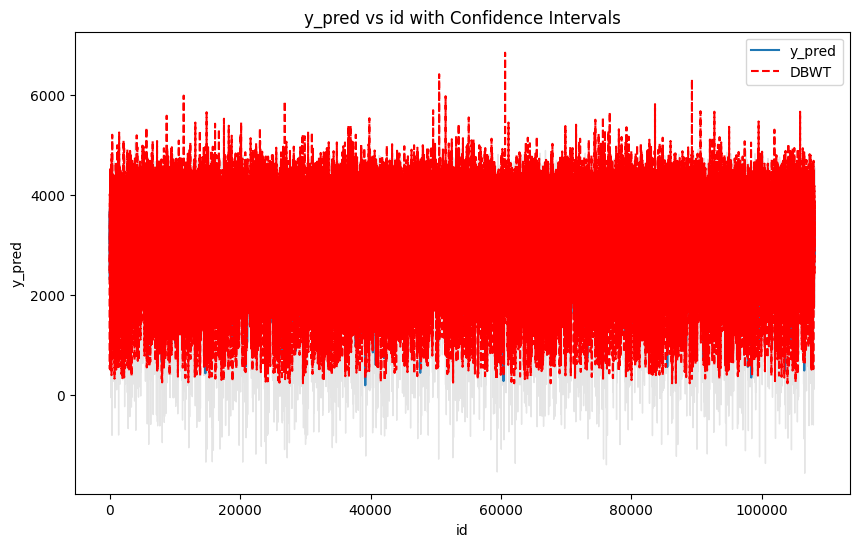

In [51]:
# Plot results
col_names = {
    'col_x': 'X Axis',
    'col_y': 'Y Axis',
    'col_y_ul': 'Upper Limit',
    'col_y_ll': 'Lower Limit',
    'col_y_true': 'True Y'
}

plot_with_confidence_intervals(
  data=df_pred.reset_index(),
  col_x="id",
  col_y="y_pred",
  col_y_ul="pi_upper",
  col_y_ll="pi_lower",
  col_y_true="DBWT",
  plot_type='line',
  col_names=col_names
)

In [52]:
plot_with_confidence_intervals_v2(
  #data=df_pred.reset_index().sample(200).sort_values(by=['id']),
  data=df_pred.reset_index().head(200).sort_values(by=['id']),
  col_x="id",
  col_y="y_pred",
  col_y_ul="pi_upper",
  col_y_ll="pi_lower",
  col_y_true="DBWT",
  plot_type='line',
  col_names=col_names
)

## 4. Predictions + CI w/ MAPIE

In [53]:
from interpret import show
from interpret.glassbox import ExplainableBoostingRegressor

from interpret import set_visualize_provider
from interpret.provider import InlineProvider
from mapie.regression import MapieRegressor
set_visualize_provider(InlineProvider())

In [55]:
dct_params = {
    'interactions':0,
    'validation_size':0,
    'outer_bags':1,
    'min_samples_leaf':1,
    'min_hessian':1e-9
}
ebm = ExplainableBoostingRegressor(**dct_params)
#ebm.fit(train_X, train_y)

In [59]:
mapie_regressor = MapieRegressor(estimator=ebm, method='plus', cv=5, n_jobs=5)
mapie_regressor = mapie_regressor.fit(train_X, train_y)
y_pred, y_pis = mapie_regressor.predict(test_X, alpha=[0.05, 0.32])

In [68]:
# CI
df_pred = df_test.copy()
df_pred["y_pred"] = y_pred
df_pred["pi_lower"] = [x[0][0] for x in y_pis]
df_pred["pi_upper"] = [x[0][1] for x in y_pis]

In [69]:
df_pred.head()

,ATTEND,BFACIL,BMI,CIG_0,DLMP_MM,DMAR,DOB_MM,DOB_TT,DOB_WK,FAGECOMB,...,RDMETH_REC,RESTATUS,RF_CESAR,RF_CESARN,SEX,WTGAIN,DBWT,y_pred,pi_lower,pi_upper
id,,,,,,,,,,,,,,,,,,,,,
0,1,1,18.5,0,12,,10,1434,5,99,...,1,1,N,0,F,24,2800,2799.999060,1659.744177,2285.576076
1,1,1,18.3,2,4,1,12,2156,6,39,...,1,1,N,0,M,18,1900,1899.999784,759.743629,1458.310546
2,1,1,27.3,0,3,2,12,1241,2,31,...,4,1,Y,2,F,27,2960,2959.999901,1819.744498,2443.954578
3,1,1,24.0,0,7,2,4,1649,2,99,...,3,1,N,0,M,29,3657,3657.001184,1974.520414,2808.604305
4,2,1,23.6,0,6,1,3,752,2,31,...,4,1,Y,2,F,37,3742,3741.999488,2106.902218,3020.870786


In [70]:
plot_with_confidence_intervals_v2(
  #data=df_pred.reset_index().sample(200).sort_values(by=['id']),
  data=df_pred.reset_index().head(200).sort_values(by=['id']),
  col_x="id",
  col_y="y_pred",
  col_y_ul="pi_upper",
  col_y_ll="pi_lower",
  col_y_true="DBWT",
  plot_type='line',
  col_names=col_names
)